In [2]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize as opt
from src.linapp import LinApp_FindSS, LinApp_Deriv, LinApp_Solve, LinApp_SSL

In [6]:
def modeldefs(Xm, Xn, Z, *mparams):
    # unpack sets
    k = Xm                            # k(t-1)
    kp = Xn                           # k(t)
    z = Z                             # z(t)
    # find variables
    y = k**alpha*np.exp((1-alpha)*z)  # y(t)
    r = alpha*y/k                     # r(t)
    w = (1-alpha)*y                   # w(t)
    c = w + (1+r-delta)*k - kp        # c(t)
    i = y - c                         # i(t)
    if gamma == 1.0:                  # u(t)
        u = np.log(c)
    else:
        u = (c**(1-gamma)-1)/(1-gamma)
    if np.isnan(u) or np.isinf(u):
        u = -1.0E+99
    return y, r, w, c, i, u

def modeldefs_nk(Xm, Xn, Z, *mparams):
    

In [7]:
def Gamma(invec, *mparams):
    # unpack input vector
    kpp = invec[0]    # k(t+2)
    kp = invec[1]     # k(t+1)
    k = invec[2]      # k(t)
    zp = invec[3]     # z(t+1)
    z = invec[4]      # z(t)
    # find period t values
    y, r, w, c, i, u = modeldefs(k, kp, z, *mparams)
    # find period t+1 values
    yp, rp, wp, cp, ip, up = modeldefs(kp, kpp, zp, *mparams)
    # calculate Euler equation (Gamma function)
    Gamma = c**(-gamma) - beta*(cp)**(-gamma)*(1+rp-delta)
    return Gamma

In [8]:
alpha = .33
beta = .95
gamma = 2.5
delta = .08
rho = .9
sigma = .02
mparams = (alpha, beta, gamma, delta, rho, sigma)

steady state

In [12]:
# find the steady state
guessXY = np.array([1.])
zbar = np.array([0.])
XYbar = LinApp_FindSS(Gamma, mparams, guessXY, zbar, 1, 0)
kbar = XYbar[0]
# check solution works
invec = np.array([kbar, kbar, kbar, 0., 0.])
check = Gamma(invec, *mparams)
print('kbar: ', kbar)
print('check:', check)

kbar:  3.8980397970046137
check: 0.0


In [13]:
zbar

array([0.])

In [14]:
ybar, rbar, wbar, cbar, ibar, ubar = modeldefs(kbar, kbar, zbar, *mparams)
print('ybar: ', ybar)
print('rbar: ', rbar)
print('wbar: ', wbar)
print('cbar: ', cbar)
print('ibar: ', ibar)
print('ubar: ', ubar)

ybar:  [1.56667628]
rbar:  [0.13263158]
wbar:  [1.04967311]
cbar:  [1.2548331]
ibar:  [0.31184318]
ubar:  [0.19239215]


In [27]:
# find derivatives of Gamma

# set the options for LinApp_Deriv
nx = 1  # number of X variables
ny = 0  # number of Y variables
nz = 1  # number of Z variables
takelogs = False  # if True the model is log-linearized, otherwise simple linearization

[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM] = LinApp_Deriv(Gamma, mparams, invec, nx, ny, nz, takelogs)

# set the options for LinApp_Solve
Sylv = False  # if True use Python's built-in Sylvester equation solver, otherwise us the code in LinApp_Solve

# NN is the autoregressive parameter in z's law of motion
NN = rho
# solve for coefficients
PP, QQ, RR, SS = LinApp_Solve(AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, NN, zbar, Sylv)
print('PP:',PP)
print('QQ', QQ)
print('SS', SS)

PP: [[0.92276239]]
QQ [[0.59443154]]
SS []


In [18]:
# generate a history of Z's
T = 1000  # number of observations to generate
# initialize Z
zhist = np.zeros((T,1))
# generate a history of epsilon shocks with mean zero and variance sigma-squared
epshist = np.random.randn(T,1)*sigma
# iteratively generate Z's starting with the first value of Z = 0
for t in range (1,T):
    zhist[t,:] = rho*zhist[t-1,:] + epshist[t,:]
# generate a history of k's
kbar2 = np.array([[kbar]])
khist, temp = LinApp_SSL(kbar2, zhist, kbar2, takelogs, PP, QQ, RR, SS)

In [19]:
# initialize histories of all other variables
yhist = np.zeros(T)
rhist = np.zeros(T)
whist = np.zeros(T)
chist = np.zeros(T)
ihist = np.zeros(T)
uhist = np.zeros(T)
# set initial values noting we started at the steady state
yhist[0] = ybar
rhist[0] = rbar
whist[0] = wbar
chist[0] = cbar
ihist[0] = ibar
uhist[0] = ubar
# compute values for all other time periods
for t in range(1, T-1):
    yhist[t], rhist[t], whist[t], chist[t], ihist[t], uhist[t] = \
        modeldefs(khist[t-1], khist[t], zhist[t,:], *mparams)

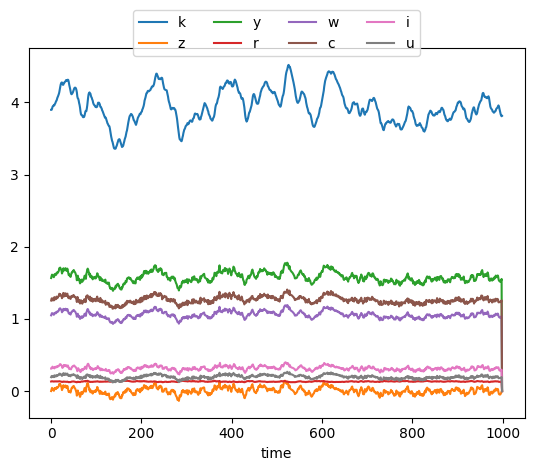

In [20]:
# plot data
t = range(0, T)
plt.plot(t, khist, label='k')
plt.plot(t, zhist, label='z')
plt.plot(t, yhist, label='y')
plt.plot(t, rhist, label='r')
plt.plot(t, whist, label='w')
plt.plot(t, chist, label='c')
plt.plot(t, ihist, label='i')
plt.plot(t, uhist, label='u')
plt.xlabel('time')
plt.legend(loc=9, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()